<h1>ANOVOS - Data Drift and Stability Computation<span class="tocSkip"></span></h1>
<p>Following notebook shows the list of "data drift and stability" related functions supported under ANOVOS package and how it can be invoked accordingly</p>
<div class="toc"><ul class="toc-item">
    <li><span><a href="#Data-Drift-Statistics" data-toc-modified-id="Data-Drift-Statistics-1">Data Drift Statistics</a></span></li>
    <li><span><a href="#Data-Stability-Index" data-toc-modified-id="Data-Stability-Index-2">Data Stability Index</a></span><ul><li><span><a href="#Data-Stability-Index-Result-Visualization" data-toc-modified-id="Data-Stability-Index-Result-Visualization-3">Data Stability Index Result Visualization</a></span></li></ul></li>
    </ul></div>

**Setting up Spark Session**

In [1]:
from anovos.shared.spark import *

**Input/Output Path** 

In [2]:
driftTargetPath = '../data/income_dataset/csv'
driftSourcePath = '../data/income_dataset/source'
stabilityPath = '../data/income_dataset/stability_index/'
outputPath = "../output/income_dataset/data_drift/"

# Data Drift Statistics
- API specification of function **drift_statistics** can be found <a href="../api_specification/anovos/data_drift/drift_detector.html#anovos.data_drift.drift_detector.drift_statistics">here</a>
- Supports 5 different ways of computing the drift statistics between target and source datasets.

In [3]:
from anovos.data_drift.drift_detector import drift_statistics

In [4]:
# Read source and target datasets
from anovos.data_ingest.data_ingest import read_dataset
target_df = read_dataset(spark, driftTargetPath,"csv",{'header':True,'inferSchema':True})
source_df = read_dataset(spark, driftSourcePath,"csv",{'header':True,'inferSchema':True})

In [5]:
# Example 1 - with mandatory arguments + drop ID column
result_PSI = drift_statistics(spark, target_df, source_df, drop_cols=['ifa'])
result_PSI.toPandas()

,attribute,PSI,flagged
0,capital-gain,0.0001,0
1,occupation,0.0004,0
2,race,0.0002,0
3,logfnl,0.0002,0
4,fnlwgt,0.0001,0
5,capital-loss,0.0001,0
6,education-num,0.0002,0
7,workclass,0.0003,0
8,native-country,0.0021,0
9,hours-per-week,0.0002,0


In [6]:
# Example 2 - selected columns + set threshold
result_PSI = drift_statistics(spark, target_df, source_df, list_of_cols=['age', 'education-num', 'capital-gain', 'hours-per-week'],
                              threshold=0.1)
result_PSI.toPandas()

,attribute,PSI,flagged
0,age,0.0004,0
1,hours-per-week,0.0002,0
2,capital-gain,0.0001,0
3,education-num,0.0002,0


In [7]:
# Example 3 - selected columns + compute statistics of JSD, HD and KS with a different bin_size
result_others = drift_statistics(spark, target_df, source_df, list_of_cols=['age', 'education-num', 'capital-gain', 'hours-per-week'], 
                                 method_type=['JSD','HD','KS'], bin_size=100)
result_others.toPandas()

,attribute,JSD,HD,KS,flagged
0,age,0.0003,0.0166,0.0058,0
1,hours-per-week,0.0003,0.0169,0.0021,0
2,capital-gain,0.0001,0.0090,0.0012,0
3,education-num,0.0000,0.0070,0.0041,0


In [8]:
# Example 4 - selected columns + save model
result_others = drift_statistics(spark, target_df, source_df, list_of_cols=['age', 'education-num', 'capital-gain', 'hours-per-week'], 
                                 pre_existing_source=False, source_path=outputPath)
result_others.toPandas()

,attribute,PSI,flagged
0,age,0.0004,0
1,hours-per-week,0.0002,0
2,capital-gain,0.0001,0
3,education-num,0.0002,0


In [9]:
# Example 5 - selected columns + use pre-saved model
result_others = drift_statistics(spark, target_df, source_df, list_of_cols=['age', 'education-num', 'capital-gain', 'hours-per-week'], 
                                 pre_existing_source=True, source_path=outputPath)
result_others.toPandas()

,attribute,PSI,flagged
0,age,0.0004,0
1,hours-per-week,0.0002,0
2,capital-gain,0.0001,0
3,education-num,0.0002,0


In [10]:
# Compute quantiles for the above variables to check their distributions
for col in ['age', 'education-num', 'capital-gain', 'hours-per-week']:
    print('#####', col, '#####')
    print(target_df.approxQuantile(col, [0.1,0.3,0.5,0.7,0.9], 0.01))
    print(source_df.approxQuantile(col, [0.1,0.3,0.5,0.7,0.9], 0.01))

##### age #####
[22.0, 29.0, 37.0, 45.0, 57.0]
[21.0, 29.0, 37.0, 45.0, 57.0]
##### education-num #####
[7.0, 9.0, 10.0, 11.0, 13.0]
[7.0, 9.0, 10.0, 11.0, 13.0]
##### capital-gain #####
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
##### hours-per-week #####
[24.0, 40.0, 40.0, 40.0, 52.0]
[25.0, 40.0, 40.0, 40.0, 52.0]


# Data Stability Index 
- API specification of function **stabilityIndex_computation** can be found <a href="../api_specification/anovos/data_drift/drift_detector.html#anovos.data_drift.drift_detector.stabilityIndex_computation">here</a>

In [11]:
from anovos.data_drift.drift_detector import stabilityIndex_computation

In [12]:
# Read input datasets
df1 = read_dataset(spark, stabilityPath+"0","csv",{'header':True,'inferSchema':True})
df2 = read_dataset(spark, stabilityPath+"1","csv",{'header':True,'inferSchema':True})
df3 = read_dataset(spark, stabilityPath+"2","csv",{'header':True,'inferSchema':True})
df4 = read_dataset(spark, stabilityPath+"3","csv",{'header':True,'inferSchema':True})
df5 = read_dataset(spark, stabilityPath+"4","csv",{'header':True,'inferSchema':True})
df6 = read_dataset(spark, stabilityPath+"5","csv",{'header':True,'inferSchema':True})
df7 = read_dataset(spark, stabilityPath+"6","csv",{'header':True,'inferSchema':True})
df8 = read_dataset(spark, stabilityPath+"7","csv",{'header':True,'inferSchema':True})
df9 = read_dataset(spark, stabilityPath+"8","csv",{'header':True,'inferSchema':True})
df10 = read_dataset(spark, stabilityPath+"9","csv",{'header':True,'inferSchema':True})
df11 = read_dataset(spark, stabilityPath+"10","csv",{'header':True,'inferSchema':True})
df12 = read_dataset(spark, stabilityPath+"11","csv",{'header':True,'inferSchema':True})

In [13]:
df1.toPandas().head(5)

,ifa,age,fnlwgt,logfnl,education_num,capital_gain,capital_loss,hours_per_week,income_label,gender_label
0,27a,19,168294,5.226069,9,0,0,40,0,0
1,32a,20,266015,5.424906,10,0,0,44,0,0
2,38a,19,544091,5.735672,9,0,0,25,0,1
3,52a,18,226956,5.355942,9,0,0,30,0,1
4,71a,19,101509,5.006505,10,0,0,32,0,0


In [13]:
# Example 1 - input only one dataset
df_stability = stabilityIndex_computation(spark, df1, appended_metric_path=outputPath+'historical_metric_1')
df_stability.toPandas() # result: should be all null because there is only one dataset

,attribute,mean_cv,stddev_cv,kurtosis_cv,mean_si,stddev_si,kurtosis_si,stability_index,flagged
0,capital_loss,NaN,NaN,NaN,None,None,None,None,-
1,capital_gain,NaN,NaN,NaN,None,None,None,None,-
2,logfnl,NaN,NaN,NaN,None,None,None,None,-
3,education_num,NaN,NaN,NaN,None,None,None,None,-
4,fnlwgt,NaN,NaN,NaN,None,None,None,None,-
5,income_label,NaN,NaN,NaN,None,None,None,None,-
6,hours_per_week,NaN,NaN,NaN,None,None,None,None,-
7,age,NaN,NaN,NaN,None,None,None,None,-
8,gender_label,NaN,NaN,NaN,None,None,None,None,-


In [14]:
# Read saved intermediate statistics in Example 1
df_intermediate = read_dataset(spark, outputPath+"historical_metric_1","csv",{'header':True,'inferSchema':True})
df_intermediate.toPandas()

,idx,attribute,mean,stddev,kurtosis
0,1,capital_loss,40.483553,265.644311,44.091347
1,1,capital_gain,143.787281,1965.965077,293.243575
2,1,logfnl,5.217221,0.291681,3.554139
3,1,education_num,8.663377,1.620281,3.873733
4,1,fnlwgt,199011.575658,112956.123267,5.508391
5,1,income_label,0.001096,0.033113,910.001098
6,1,hours_per_week,29.103070,12.360231,3.088445
7,1,age,18.835526,1.053627,1.924572
8,1,gender_label,0.476974,0.499744,1.008501


In [15]:
# Example 2 - input a few more datasets and append to existing result
df_stability = stabilityIndex_computation(spark, df2,df3,df4,df5, existing_metric_path=outputPath+'historical_metric_1', 
                                          appended_metric_path=outputPath+'historical_metric_1to5',threshold=2)
df_stability.toPandas()

,attribute,mean_cv,stddev_cv,kurtosis_cv,mean_si,stddev_si,kurtosis_si,stability_index,flagged
0,capital_loss,0.3178,0.1611,0.3552,1,2,1,1.3,1
1,capital_gain,0.5833,0.4098,0.3902,0,1,1,0.5,1
2,logfnl,0.0016,0.0320,0.0516,4,3,3,3.5,0
3,education_num,0.0606,0.1482,0.0981,3,2,3,2.7,0
4,fnlwgt,0.0175,0.0212,0.2742,4,4,1,3.4,0
5,income_label,0.8876,0.5794,1.8351,0,0,0,0.0,1
6,hours_per_week,0.1326,0.0877,0.2615,2,3,1,2.1,0
7,age,0.1806,0.1304,0.1169,2,2,2,2.0,0
8,gender_label,0.1682,0.0317,0.2063,2,3,1,2.1,0


In [16]:
# Example 3 - input rest of the datasets and append to previous results
df_stability = stabilityIndex_computation(spark, df6, df7, df8, df9, df10, df11, df12, existing_metric_path=outputPath+'historical_metric_1to5', 
                                          appended_metric_path=outputPath+'historical_metric_1to12',threshold=2)
df_stability.toPandas()

,attribute,mean_cv,stddev_cv,kurtosis_cv,mean_si,stddev_si,kurtosis_si,stability_index,flagged
0,capital_loss,0.3259,0.1847,0.4452,1,2,1,1.3,1
1,capital_gain,0.4992,0.3368,0.5583,1,1,0,0.8,1
2,logfnl,0.0035,0.0363,0.0435,4,3,3,3.5,0
3,education_num,0.0531,0.1533,0.1249,3,2,2,2.5,0
4,fnlwgt,0.0450,0.0623,0.2937,3,3,1,2.6,0
5,income_label,0.5837,0.3867,3.0415,0,1,0,0.3,1
6,hours_per_week,0.1140,0.1284,0.2194,2,2,1,1.8,1
7,age,0.3513,0.8018,0.2021,1,0,1,0.7,1
8,gender_label,0.1775,0.0345,0.1879,2,3,2,2.3,0


In [17]:
# Read saved intermediate statistics in Example 3
df_intermediate = read_dataset(spark, outputPath+"historical_metric_1to12","csv",{'header':True,'inferSchema':True})
df_intermediate.toPandas()

,idx,attribute,mean,stddev,kurtosis
0,1,capital_loss,40.483553,265.644311,44.091347
1,1,capital_gain,143.787281,1965.965077,293.243575
2,1,logfnl,5.217221,0.291681,3.554139
3,1,education_num,8.663377,1.620281,3.873733
4,1,fnlwgt,199011.575658,112956.123267,5.508391
...,...,...,...,...,...
103,12,fnlwgt,176143.994493,98217.730197,7.374279
104,12,income_label,0.243392,0.429366,2.430286
105,12,hours_per_week,33.231278,15.178810,3.091868
106,12,age,65.799559,4.977072,2.765278


## Data Stability Index Result Visualization
The following function (not included in the module) can be used to visualise the trend of each metric for an attribute.

In [18]:
def plot_attribute_result(attribute_name, df_stability_result, df_intermediate,  
                          metric_weightages={'mean':0.5,'stddev':0.3,'kurtosis':0.2}):
    """
    :params attribute_name: name of the attribute
    :params df_stability_result: output of stabilityIndex_computation
    :params df_intermediate: intermediate output of stabilityIndex_computation
    :params metric_weightages: same metric weightages used in stabilityIndex_computation
    """
    from pyspark.sql import functions as F
    metric_si_df = df_stability_result.where(F.col('attribute')==attribute_name).select('mean_si', 'stddev_si', 'kurtosis_si', 'stability_index').take(1)
    metric_si = {}
    metric_si['mean'] = metric_si_df[0]['mean_si']
    metric_si['stddev'] = metric_si_df[0]['stddev_si']
    metric_si['kurtosis'] = metric_si_df[0]['kurtosis_si']
    attribute_si = metric_si_df[0]['stability_index']
    
    metric_stats = {}
    metric_stats['mean'] = df_intermediate.where(F.col('attribute')==attribute_name).select('mean').rdd.flatMap(lambda x: x).collect()
    metric_stats['stddev'] = df_intermediate.where(F.col('attribute')==attribute_name).select('stddev').rdd.flatMap(lambda x: x).collect()
    metric_stats['kurtosis'] = df_intermediate.where(F.col('attribute')==attribute_name).select('kurtosis').rdd.flatMap(lambda x: x).collect()
    
    import matplotlib.pyplot as plt
    import math
    metrics = list(metric_weightages.keys())

    figure, axis = plt.subplots(1, len(metrics), figsize=(5*len(metrics),4))
    figure.suptitle('{}:Final Attribute Stability={}'.format(attribute_name, attribute_si))
    for i, metric in enumerate(metrics):
        metric_stability = metric_si[metric]
        metric_weightage = metric_weightages[metric]
        y = metric_stats[metric]
        axis[i].plot(list(range(1, len(y)+1)), y)
        axis[i].set_title('{}: Stability={}, Weightage={}'.format(metric, metric_stability, metric_weightage))

In [19]:
df_intermediate = read_dataset(spark, outputPath+"historical_metric_1to12","csv",{'header':True,'inferSchema':True})

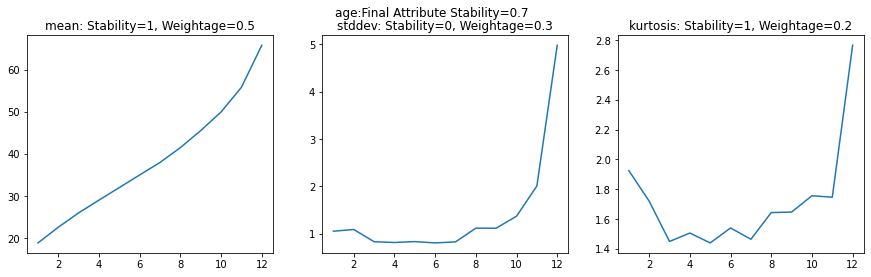

In [20]:
# Example 1 - attribute age
plot_attribute_result('age', df_stability, df_intermediate)

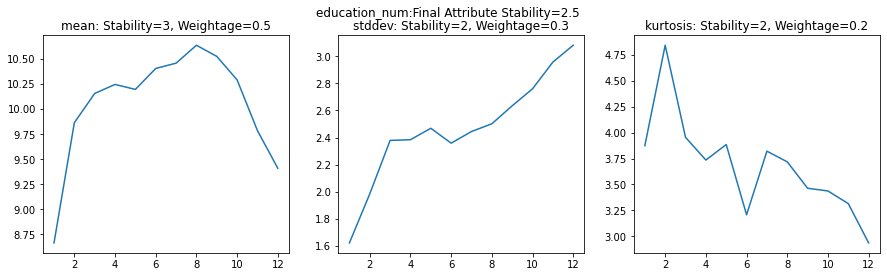

In [21]:
# Example 2 - attribute education_num
plot_attribute_result('education_num', df_stability, df_intermediate)

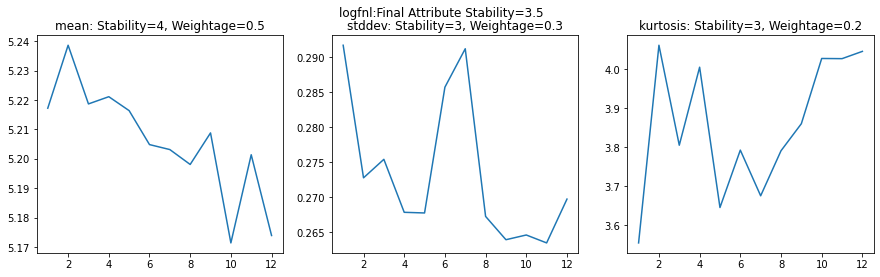

In [22]:
# Example 3 - attribute logfnl
plot_attribute_result('logfnl', df_stability, df_intermediate)